# *(Song, et al., 2016)*: Training excitatory-inhibitory recurrent network

Implementation of the paper:

- Song, H. F. ,  G. R. Yang , and  X. J. Wang . "Training Excitatory-Inhibitory Recurrent Neural Networks for Cognitive Tasks: A Simple and Flexible Framework." Plos Computational Biology 12.2(2016):e1004792.

The original code is based on PyTorch (https://github.com/gyyang/nn-brain/blob/master/EI_RNN.ipynb). However, comparing with the PyTorch codes, the training on BrainPy speeds up nearly four folds. 

Here we will train recurrent neural network with excitatory and inhibitory neurons on a simple perceptual decision making task.

In [1]:
import brainpy as bp
import brainpy.math as bm
bp.math.set_platform('cpu')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Defining a perceptual decision making task

In [3]:
# We will import the task from the neurogym library.
# Please install neurogym:
# 
# https://github.com/neurogym/neurogym

import neurogym as ngym

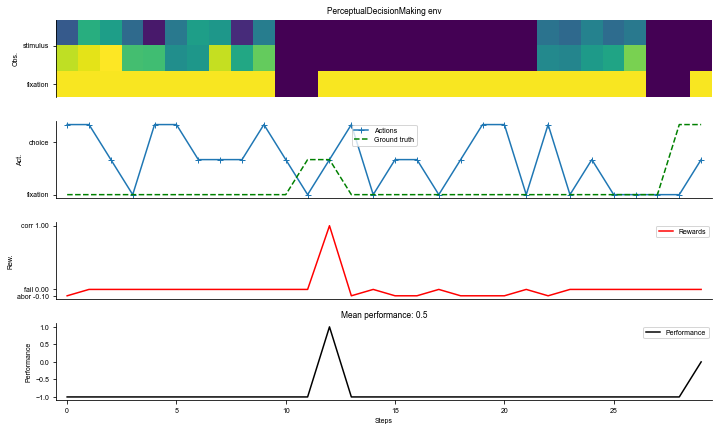

In [4]:
# Environment
task = 'PerceptualDecisionMaking-v0'
timing = {
  'fixation': ('choice', (50, 100, 200, 400)),
  'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task,
                       env_kwargs=kwargs,
                       batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2, fig_kwargs={'figsize': (10, 6)})
plt.show()

In [5]:
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
batch_size = dataset.batch_size

print(f'Input size = {input_size}')
print(f'Output size = {output_size}')
print(f'Bacth size = {batch_size}')

Input size = 3
Output size = 3
Bacth size = 16


## Define E-I recurrent network

Here we define a E-I recurrent network, in particular, no self-connections are allowed.

In [6]:
class RNN(bp.dyn.DynamicalSystem):
  r"""E-I RNN.

  The RNNs are described by the equations

  .. math::

      \begin{gathered}
      \tau \dot{\mathbf{x}}=-\mathbf{x}+W^{\mathrm{rec}} \mathbf{r}+W^{\mathrm{in}} 
      \mathbf{u}+\sqrt{2 \tau \sigma_{\mathrm{rec}}^{2}} \xi \\
      \mathbf{r}=[\mathbf{x}]_{+} \\
      \mathbf{z}=W^{\text {out }} \mathbf{r}
      \end{gathered}

  In practice, the continuous-time dynamics are discretized to Euler form
  in time steps of size :math:`\Delta t` as

  .. math::

     \begin{gathered}
      \mathbf{x}_{t}=(1-\alpha) \mathbf{x}_{t-1}+\alpha\left(W^{\mathrm{rec}} \mathbf{r}_{t-1}+ 
      W^{\mathrm{in}} \mathbf{u}_{t}\right)+\sqrt{2 \alpha \sigma_{\mathrm{rec}}^{2}} \mathbf{N}(0,1) \\
      \mathbf{r}_{t}=\left[\mathbf{x}_{t}\right]_{+} \\
      \mathbf{z}_{t}=W^{\mathrm{out}} \mathbf{r}_{t}
      \end{gathered}

  where :math:`\alpha = \Delta t/\tau` and :math:`N(0, 1)` are normally distributed
  random numbers with zero mean and unit variance, sampled independently at every time step.
  """

  def __init__(self, num_input, num_hidden, num_output, num_batch,
               dt=None, e_ratio=0.8, sigma_rec=0., seed=None,
               w_ir=bp.init.KaimingUniform(scale=1.),
               w_rr=bp.init.KaimingUniform(scale=1.),
               w_ro=bp.init.KaimingUniform(scale=1.)):
    super(RNN, self).__init__()

    # parameters
    self.tau = 100
    self.num_batch = num_batch
    self.num_input = num_input
    self.num_hidden = num_hidden
    self.num_output = num_output
    self.e_size = int(num_hidden * e_ratio)
    self.i_size = num_hidden - self.e_size
    if dt is None:
      self.alpha = 1
    else:
      self.alpha = dt / self.tau
    self.sigma_rec = (2 * self.alpha) ** 0.5 * sigma_rec  # Recurrent noise
    self.rng = bm.random.RandomState(seed=seed)

    # hidden mask
    mask = np.tile([1] * self.e_size + [-1] * self.i_size, (num_hidden, 1))
    np.fill_diagonal(mask, 0)
    self.mask = bm.asarray(mask, dtype=bm.float_)

    # input weight
    self.w_ir = bm.TrainVar(bp.init.parameter(w_ir, (num_input, num_hidden)))

    # recurrent weight
    bound = 1 / num_hidden ** 0.5
    self.w_rr = bm.TrainVar(bp.init.parameter(w_rr, (num_hidden, num_hidden)))
    self.w_rr[:, :self.e_size] /= (self.e_size / self.i_size)
    self.b_rr = bm.TrainVar(self.rng.uniform(-bound, bound, num_hidden))

    # readout weight
    bound = 1 / self.e_size ** 0.5
    self.w_ro = bm.TrainVar(bp.init.parameter(w_ro, (self.e_size, num_output)))
    self.b_ro = bm.TrainVar(self.rng.uniform(-bound, bound, num_output))

    # variables
    self.h = bm.Variable(bm.zeros((num_batch, num_hidden)))
    self.o = bm.Variable(bm.zeros((num_batch, num_output)))

  def cell(self, x, h):
    ins = x @ self.w_ir + h @ (bm.abs(self.w_rr) * self.mask) + self.b_rr
    state = h * (1 - self.alpha) + ins * self.alpha
    state += self.sigma_rec * self.rng.randn(self.num_hidden)
    return bm.relu(state)

  def readout(self, h):
    return h @ self.w_ro + self.b_ro

  def make_update(self, h: bm.JaxArray, o: bm.JaxArray):
    def f(x):
      h.value = self.cell(x, h.value)
      o.value = self.readout(h.value[:, :self.e_size])

    return f

  def predict(self, xs):
    self.h[:] = 0.
    f = bm.make_loop(self.make_update(self.h, self.o),
                     dyn_vars=self.vars(),
                     out_vars=[self.h, self.o])
    return f(xs)

  def loss(self, xs, ys):
    hs, os = self.predict(xs)
    os = os.reshape((-1, os.shape[-1]))
    return bp.losses.cross_entropy_loss(os, ys.flatten())

## Train the network on the decision making task

In [7]:
# Instantiate the network and print information
hidden_size = 50
net = RNN(num_input=input_size,
          num_hidden=hidden_size,
          num_output=output_size,
          num_batch=batch_size,
          dt=env.dt,
          sigma_rec=0.15)

In [8]:
# Adam optimizer
opt = bp.optimizers.Adam(lr=0.001, train_vars=net.train_vars().unique())

In [9]:
# gradient function
grad_f = bm.grad(net.loss,
                 dyn_vars=net.vars(),
                 grad_vars=net.train_vars().unique(),
                 return_value=True)

In [10]:
@bm.jit
@bm.function(nodes=(net, opt))
def train(xs, ys):
  grads, loss = grad_f(xs, ys)
  opt.update(grads)
  return loss

The training speeds up nearly 4 times, comparing with the original PyTorch codes.

In [11]:
running_loss = 0
print_step = 200
for i in range(5000):
  inputs, labels = dataset()
  inputs = bm.asarray(inputs)
  labels = bm.asarray(labels)
  loss = train(inputs, labels)
  running_loss += loss
  if i % print_step == (print_step - 1):
    running_loss /= print_step
    print('Step {}, Loss {:0.4f}'.format(i + 1, running_loss))
    running_loss = 0

Step 200, Loss 0.5393
Step 400, Loss 0.3891
Step 600, Loss 0.2908
Step 800, Loss 0.2237
Step 1000, Loss 0.1735
Step 1200, Loss 0.1410
Step 1400, Loss 0.1224
Step 1600, Loss 0.1070
Step 1800, Loss 0.0985
Step 2000, Loss 0.0896
Step 2200, Loss 0.0853
Step 2400, Loss 0.0805
Step 2600, Loss 0.0777
Step 2800, Loss 0.0738
Step 3000, Loss 0.0747
Step 3200, Loss 0.0708
Step 3400, Loss 0.0710
Step 3600, Loss 0.0700
Step 3800, Loss 0.0669
Step 4000, Loss 0.0660
Step 4200, Loss 0.0670
Step 4400, Loss 0.0661
Step 4600, Loss 0.0665
Step 4800, Loss 0.0642
Step 5000, Loss 0.0638


## Run the network post-training and record neural activity

In [12]:
predict = bm.jit(net.predict, dyn_vars=net.vars())

In [13]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500), 'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
  env.new_trial()
  ob, gt = env.ob, env.gt
  inputs = bm.asarray(ob[:, np.newaxis, :])
  rnn_activity, action_pred = predict(inputs)

  # Compute performance
  action_pred = action_pred.numpy()
  choice = np.argmax(action_pred[-1, 0, :])
  correct = choice == gt[-1]

  # Log trial info
  trial_info = env.trial
  trial_info.update({'correct': correct, 'choice': choice})
  trial_infos[i] = trial_info

  # Log stimulus period activity
  rnn_activity = rnn_activity.numpy()[:, 0, :]
  activity_dict[i] = rnn_activity

  # Compute stimulus selectivity for all units
  # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
  rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
  stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Average performance 0.844


### Plot neural activity from sample trials

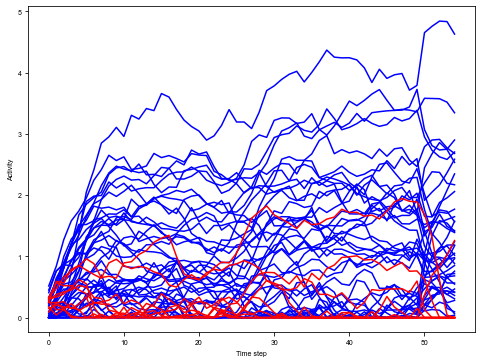

In [14]:
trial = 2
plt.figure(figsize=(8, 6))
_ = plt.plot(activity_dict[trial][:, :net.e_size], color='blue', label='Excitatory')
_ = plt.plot(activity_dict[trial][:, net.e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')
plt.show()

### Compute stimulus selectivity for sorting neurons

Here for each neuron we compute its stimulus period selectivity $d'$

In [15]:
mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
  activity = np.concatenate(stim_activity[ground_truth], axis=0)
  mean_activity.append(np.mean(activity, axis=0))
  std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0] ** 2 + std_activity[1] ** 2 + 1e-7) / 2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:net.e_size]),
                           np.argsort(selectivity[net.e_size:]) + net.e_size))

### Plot network connectivity sorted by stimulus selectivity

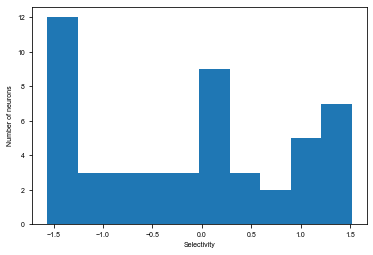

In [16]:
# Plot distribution of stimulus selectivity
plt.figure(figsize=(6, 4))
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')
plt.show()

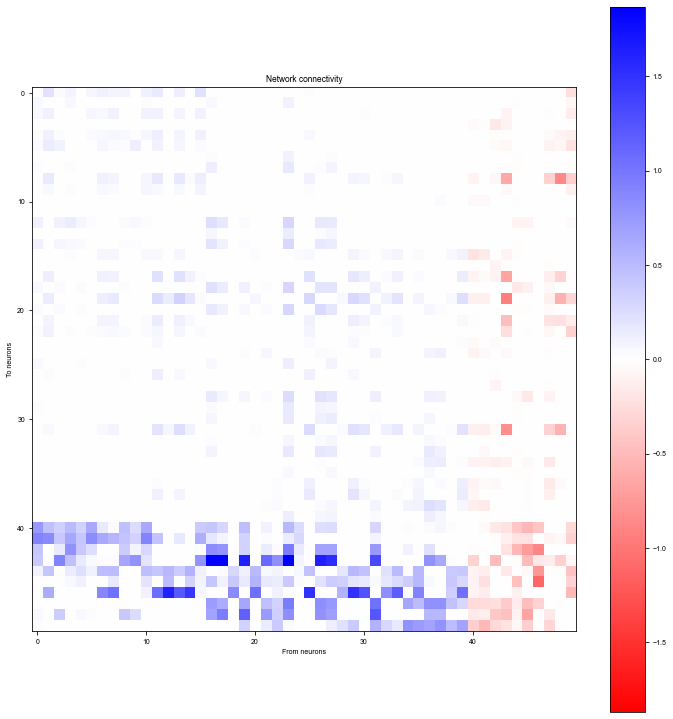

In [17]:
W = (bm.abs(net.w_rr) * net.mask).numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))

plt.figure(figsize=(10, 10))
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')
plt.tight_layout()
plt.show()